# **Waste Material Segregation for Improving Waste Management**

## **Objective**

The objective of this project is to implement an effective waste material segregation system using convolutional neural networks (CNNs) that categorises waste into distinct groups. This process enhances recycling efficiency, minimises environmental pollution, and promotes sustainable waste management practices.

The key goals are:

* Accurately classify waste materials into categories like cardboard, glass, paper, and plastic.
* Improve waste segregation efficiency to support recycling and reduce landfill waste.
* Understand the properties of different waste materials to optimise sorting methods for sustainability.

## **Data Understanding**

The Dataset consists of images of some common waste materials.

1. Food Waste
2. Metal
3. Paper
4. Plastic
5. Other
6. Cardboard
7. Glass


**Data Description**

* The dataset consists of multiple folders, each representing a specific class, such as `Cardboard`, `Food_Waste`, and `Metal`.
* Within each folder, there are images of objects that belong to that category.
* However, these items are not further subcategorised. <br> For instance, the `Food_Waste` folder may contain images of items like coffee grounds, teabags, and fruit peels, without explicitly stating that they are actually coffee grounds or teabags.

## **1. Load the data**

Load and unzip the dataset zip file.

**Import Necessary Libraries**

In [1]:
# Recommended versions:

# numpy version: 1.26.4
# pandas version: 2.2.2
# seaborn version: 0.13.2
# matplotlib version: 3.10.0
# PIL version: 11.1.0
# tensorflow version: 2.18.0
# keras version: 3.8.0
# sklearn version: 1.6.1

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight

#predefined model
from tensorflow.keras.applications import MobileNetV2

import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
print("numpy version:", np.__version__)
print("pandas version:", pd.__version__)
print("seaborn version:", sns.__version__)
print("matplotlib version:", matplotlib.__version__)
print("PIL (Pillow) version:", Image.__version__)
print("tensorflow version:", tf.__version__)
print("keras version:", tf.keras.__version__)
print("sklearn version:", sklearn.__version__)

numpy version: 2.1.3
pandas version: 2.2.3
seaborn version: 0.13.2
matplotlib version: 3.10.1
PIL (Pillow) version: 11.2.1
tensorflow version: 2.19.0
keras version: 3.9.2
sklearn version: 1.6.1


In [3]:
# Import essential libraries
import zipfile
import os
import shutil
import math

In [4]:
# Its a relative path to the data directory
data_dir = r'data' 


## **2. Data Preparation** <font color=red> [25 marks] </font><br>


### **2.1 Load and Preprocess Images** <font color=red> [8 marks] </font><br>

Let us create a function to load the images first. We can then directly use this function while loading images of the different categories to load and crop them in a single step.

#### **2.1.1** <font color=red> [3 marks] </font><br>
Create a function to load the images.

In [5]:
# Create a function to load the raw images

def plot_images(images, labels, class_names, num_images=5):
    images_per_row = 4
    num_rows = math.ceil(num_images / images_per_row)
    plt.figure(figsize=(images_per_row * 3, num_rows * 3))
    for i in range(num_images):
        plt.subplot(num_rows, images_per_row, i + 1)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.title(labels[i])
        plt.axis('off')
    plt.show()

#### **2.1.2** <font color=red> [5 marks] </font><br>
Load images and labels.

Load the images from the dataset directory. Labels of images are present in the subdirectories.

Verify if the images and labels are loaded correctly.

In [6]:
# Get the images and their labels

images = []
labels = []
class_names = sorted(os.listdir(data_dir))

for label_idx, class_name in enumerate(class_names):
    class_path = os.path.join(data_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    for img_file in os.listdir(class_path):
        img_path = os.path.join(class_path, img_file)
        try:
            with Image.open(img_path) as img:
                img = img.convert('RGB')   # Ensures 3 channels
                img_array = np.array(img)
                images.append(img_array)
                labels.append(label_idx)
        except Exception as e:
            print(f"Error loading {img_path}: {e}")

In [7]:
label_names = [class_names[label] for label in labels]
unique_classes, counts = np.unique(label_names, return_counts=True)

class_names = [str(cls) for cls in unique_classes]
counts = [int(counts) for counts in counts]

print("Class Names:", class_names)
print("Class Counts:", counts)

Class Names: ['Cardboard', 'Food_Waste', 'Glass', 'Metal', 'Other', 'Paper', 'Plastic']
Class Counts: [540, 1000, 750, 1000, 1010, 1030, 2295]


Perform any operations, if needed, on the images and labels to get them into the desired format.

### **2.2 Data Visualisation** <font color=red> [9 marks] </font><br>

#### **2.2.1** <font color=red> [3 marks] </font><br>
Create a bar plot to display the class distribution

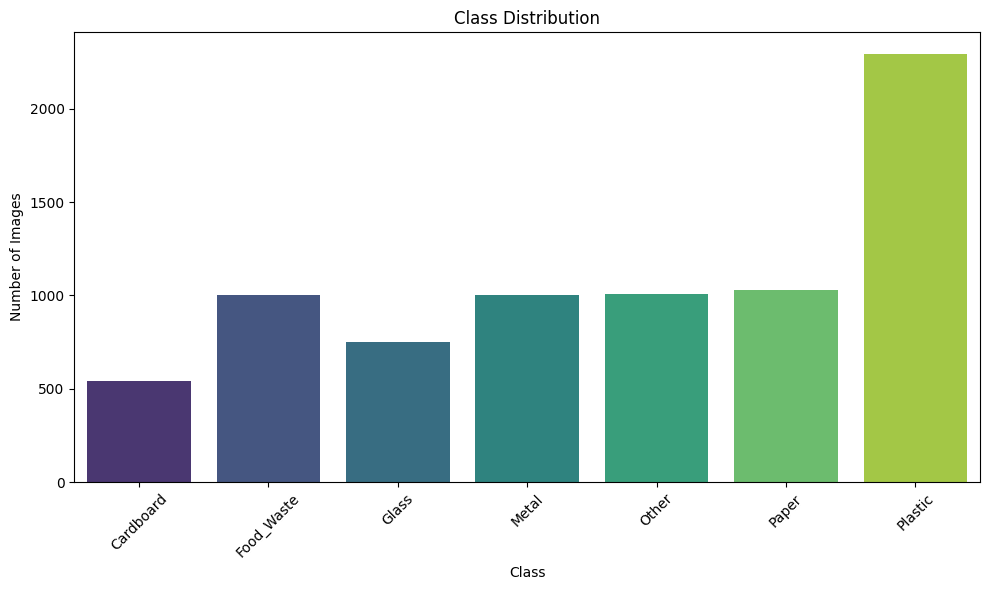

In [8]:
# Visualise Data Distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=class_names, y=counts, palette='viridis')

plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


* Plastic has the highest number of images by a large margin, exceeding 2200, indicating a class imbalance in the dataset.

* Cardboard has the lowest representation, with fewer than 600 images, which could affect model performance on this class.

* The rest of the classes—Food Waste, Paper, Other, Glass, and Metal—are relatively balanced, each having between 750 to 1050 images

#### **2.2.2** <font color=red> [3 marks] </font><br>
Visualise some sample images

Sample images: 7
Sample labels: 7


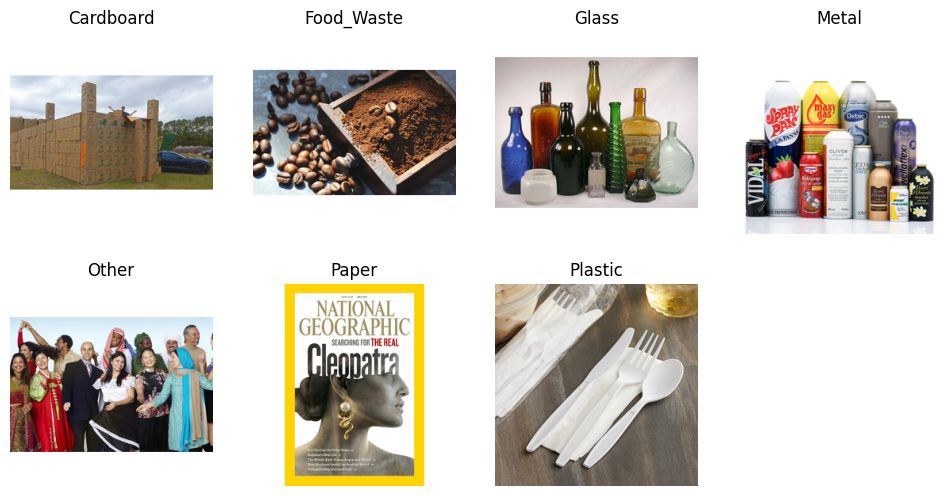

In [9]:
# Visualise Sample Images (across different labels)
sample_images = []
sample_labels = []

# Ensure labels is a list (not NumPy array)
labels_list = list(labels)

# Loop through the unique class names and collect one image per class
for class_name in unique_classes.tolist():
     # Ensure class_name corresponds to an integer (1 to 7)
    class_idx = unique_classes.tolist().index(class_name)   # Get the integer index (1-7)

    # Find all indices where class_idx appears in the labels_list
    class_indices = [i for i, label in enumerate(labels_list) if label == class_idx]

    if class_indices:
        # Get the first occurrence index
        first_index = class_indices[0]

        # Get the image and label
        img_to_show = images[first_index]
        sample_images.append(img_to_show)
        sample_labels.append(class_names[class_idx])


# Debugging the length of sample_images and sample_labels
print(f"Sample images: {len(sample_images)}")
print(f"Sample labels: {len(sample_labels)}")

# plot images
plot_images(sample_images, sample_labels, class_names, num_images=7)


#### **2.2.3** <font color=red> [3 marks] </font><br>
Based on the smallest and largest image dimensions, resize the images.

In [10]:
# Find the smallest and largest image dimensions from the data set
#(height, width, channels)
heights = [img.shape[0] for img in images]  # shape[0] gives height
widths = [img.shape[1] for img in images]  # shape[1] gives width

max_width = max(widths)
min_width = min(widths)

max_height = max(heights)
min_height = min(heights)

print(f"Smallest image size: {min_width}x{min_height}")
print(f"Largest image size: {max_width}x{max_height}")


Smallest image size: 256x256
Largest image size: 256x256


In [11]:
image_size = (128, 128)
resized_images = []

for img_array in images:
    img = Image.fromarray(img_array)
    img = img.resize(image_size)
    resized_array = np.array(img)
    resized_images.append(resized_array)

# assign resized_images to images
images = resized_images
X = np.array(images)
y = np.array(labels)

### **2.3 Encoding the classes** <font color=red> [3 marks] </font><br>

There are seven classes present in the data.

We have extracted the images and their labels, and visualised their distribution. Now, we need to perform encoding on the labels. Encode the labels suitably.

####**2.3.1** <font color=red> [3 marks] </font><br>
Encode the target class labels.

In [12]:
# Encode the labels suitably
def encode_target_class(labels,class_names):
  num_classes = len(class_names)
  labels_encoded = to_categorical(labels, num_classes)
  return labels_encoded

In [13]:
y_encoded = encode_target_class(y, class_names)
y_encoded.shape

(7625, 7)

### **2.4 Data Splitting** <font color=red> [5 marks] </font><br>

#### **2.4.1** <font color=red> [5 marks] </font><br>
Split the dataset into training and validation sets

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )

# normalize data between 0 - 1
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

print(f"train shape: {X_train.shape}, Labels: {y_train.shape}")
print(f"test shape: {X_test.shape}, Labels: {y_test.shape}")


train shape: (6100, 128, 128, 3), Labels: (6100, 7)
test shape: (1525, 128, 128, 3), Labels: (1525, 7)


## **3. Model Building and Evaluation** <font color=red> [20 marks] </font><br>

### **3.1 Model building and training** <font color=red> [15 marks] </font><br>

#### **3.1.1** <font color=red> [10 marks] </font><br>
Build and compile the model. Use 3 convolutional layers. Add suitable normalisation, dropout, and fully connected layers to the model.

Test out different configurations and report the results in conclusions.

In [15]:
# Build and compile the model

def build_dynamic_cnn(input_shape, num_classes, num_conv_layers=3):
    model = models.Sequential()

    filters = 32
    model.add(layers.Input(shape=input_shape))

    for i in range(num_conv_layers):
        model.add(layers.Conv2D(filters, (3, 3), activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Dropout(0.2))
        filters *= 2

    model.add(layers.Flatten())

    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.5))



    model.add(layers.Dense(num_classes, activation='softmax'))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [16]:
input_shape = X_train.shape[1:]  # (height, width, channels)
num_classes = len(class_names)

model_scratch = build_dynamic_cnn(input_shape, num_classes, num_conv_layers=4)
model_scratch.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,113,031 (19.50 MB)

 Trainable params: 5,112,071 (19.50 MB)

 Non-trainable params: 960 (3.75 KB)

Implement early stopping and checkpointing¶
- EarlyStopping: Stops training when validation loss stops improving.
- ModelCheckpoint: Saves the best model during training

In [17]:
callbacks = [
    #Stops training early if the validation metric stops improving. Helps prevent overfitting and saves time.
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    #Saves your model automatically during training. Keeps only the best model based on a chosen metric.
    ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss'),
    #Lowers the learning rate when the model hits a plateau. Useful for fine-tuning when progress slows.
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1)
]

#### **3.1.2** <font color=red> [5 marks] </font><br>
Train the model.

Use appropriate metrics and callbacks as needed.

In [18]:
# Training
history = model_scratch.fit(X_train, y_train, epochs=30,batch_size=32,
                    validation_data=(X_test, y_test),
                    callbacks = callbacks
                    )

Epoch 1/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 68s 319ms/step - accuracy: 0.2756 - loss: 2.6595 - val_accuracy: 0.1325 - val_loss: 6.3489 - learning_rate: 1.0000e-04
Epoch 2/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 60s 312ms/step - accuracy: 0.3870 - loss: 1.6424 - val_accuracy: 0.1757 - val_loss: 3.6126 - learning_rate: 1.0000e-04
Epoch 3/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 60s 312ms/step - accuracy: 0.4047 - loss: 1.5737 - val_accuracy: 0.3213 - val_loss: 2.2800 - learning_rate: 1.0000e-04
Epoch 4/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 60s 312ms/step - accuracy: 0.4574 - loss: 1.4490 - val_accuracy: 0.4007 - val_loss: 2.0104 - learning_rate: 1.0000e-04
Epoch 5/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 60s 314ms/step - accuracy: 0.4828 - loss: 1.3789 - val_accuracy: 0.4426 - val_loss: 1.7697 - learning_rate: 1.0000e-04
Epoch 6/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 60s 313ms/step - accuracy: 0.5219 - loss: 1.3201 - val_accuracy: 0.4538 - val_loss: 1.8274 - learning_rate: 1.0000e-04
Epoch 7/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 97s 50


* Model is overfitted
* Not good on validation data
* Training accuracy - 70.80%
* Test accuracy - 57.51%


**Let's try with predefined model MobileNetV2**

***This is for learning only (not mentioned in assignment)***



In [19]:
base_model = MobileNetV2(include_top=False, input_shape=(128, 128, 3), weights='imagenet')
base_model.trainable = False  # freeze for feature extraction

model_mobile_net = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])
model_mobile_net.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_mobile_net_1 = model_mobile_net.fit(X_train, y_train,
                                            epochs=8,batch_size=64,
                    validation_data=(X_test, y_test),
                    callbacks = callbacks
                    )

Epoch 1/8
96/96 ━━━━━━━━━━━━━━━━━━━━ 39s 328ms/step - accuracy: 0.5251 - loss: 1.8591 - val_accuracy: 0.7574 - val_loss: 1.1343 - learning_rate: 0.0010
Epoch 2/8
96/96 ━━━━━━━━━━━━━━━━━━━━ 26s 275ms/step - accuracy: 0.7720 - loss: 1.0541 - val_accuracy: 0.7718 - val_loss: 1.0178 - learning_rate: 0.0010
Epoch 3/8
96/96 ━━━━━━━━━━━━━━━━━━━━ 26s 274ms/step - accuracy: 0.8246 - loss: 0.8535 - val_accuracy: 0.7974 - val_loss: 0.9577 - learning_rate: 0.0010
Epoch 4/8
96/96 ━━━━━━━━━━━━━━━━━━━━ 25s 255ms/step - accuracy: 0.8613 - loss: 0.7414 - val_accuracy: 0.8013 - val_loss: 0.9167 - learning_rate: 0.0010
Epoch 5/8
96/96 ━━━━━━━━━━━━━━━━━━━━ 24s 249ms/step - accuracy: 0.8911 - loss: 0.6418 - val_accuracy: 0.8131 - val_loss: 0.8782 - learning_rate: 0.0010
Epoch 6/8
96/96 ━━━━━━━━━━━━━━━━━━━━ 29s 305ms/step - accuracy: 0.9037 - loss: 0.5868 - val_accuracy: 0.8164 - val_loss: 0.8751 - learning_rate: 0.0010
Epoch 7/8
96/96 ━━━━━━━━━━━━━━━━━━━━ 29s 300ms/step - accuracy: 0.9174 - loss: 0.5278 - 


Training accuracy = 93.13 %

Validation accuracy = 82.95%


**This is working fine but lets try some tweaks by unfreezing few pre trained model layers**

In [20]:
# Unfreeze top N layers for fine-tuning
base_model.trainable = True

# Freeze bottom layers
for layer in base_model.layers[:-30]:
    layer.trainable = False

model_mobile_net.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Continue training
history_mobile_net_2 = model_mobile_net.fit(
    X_train, y_train, batch_size=64,
    validation_data=(X_test, y_test),
    epochs=8,
    callbacks=callbacks
)

Epoch 1/8
96/96 ━━━━━━━━━━━━━━━━━━━━ 50s 385ms/step - accuracy: 0.7492 - loss: 0.9891 - val_accuracy: 0.8125 - val_loss: 0.8743 - learning_rate: 1.0000e-05
Epoch 2/8
96/96 ━━━━━━━━━━━━━━━━━━━━ 46s 483ms/step - accuracy: 0.8103 - loss: 0.8000 - val_accuracy: 0.8144 - val_loss: 0.8844 - learning_rate: 1.0000e-05
Epoch 3/8
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step - accuracy: 0.8560 - loss: 0.6761
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
96/96 ━━━━━━━━━━━━━━━━━━━━ 56s 582ms/step - accuracy: 0.8559 - loss: 0.6761 - val_accuracy: 0.8216 - val_loss: 0.8804 - learning_rate: 1.0000e-05
Epoch 4/8
96/96 ━━━━━━━━━━━━━━━━━━━━ 63s 656ms/step - accuracy: 0.8789 - loss: 0.6155 - val_accuracy: 0.8210 - val_loss: 0.8707 - learning_rate: 2.0000e-06
Epoch 5/8
96/96 ━━━━━━━━━━━━━━━━━━━━ 63s 660ms/step - accuracy: 0.8749 - loss: 0.6205 - val_accuracy: 0.8216 - val_loss: 0.8652 - learning_rate: 2.0000e-06
Epoch 6/8
96/96 ━━━━━━━━━━━━━━━━━━━━ 49s 512ms/step - accuracy: 0.87


Train accuracy = 89.31%

Validation accuracy = 81.97%

**This model is working fine as per results**

### **3.2 Model Testing and Evaluation** <font color=red> [5 marks] </font><br>

#### **3.2.1** <font color=red> [5 marks] </font><br>
Evaluate the model on test dataset. Derive appropriate metrics.

In [21]:
# Evaluate on the test set; display suitable metrics

# we have 2 models -
# 1 -- Without predefined model (model_scratch)
# 2 -- with mobilenet model (model_mobile_net)

test_loss, test_acc = model_scratch.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy using custom model: {test_acc}")


test_loss, test_acc = model_mobile_net.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy using mobile net: {test_acc}")

48/48 - 3s - 73ms/step - accuracy: 0.5698 - loss: 1.3743
Test accuracy using custom model: 0.5698360800743103
48/48 - 6s - 122ms/step - accuracy: 0.8197 - loss: 0.8557
Test accuracy using mobile net: 0.8196721076965332


**After Seeing both models- it is quite clear that predefined model is working fine.**

**I tried multiple configuration for custom cnn model but could not make much progress**

Tried combinatons are -

* with/without dropout
* with/without batch normalization
* increasing CNN layers
* adding multiple dense layers
* changing hyperparameter for dense layer

In [22]:
def plot_metrics(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()


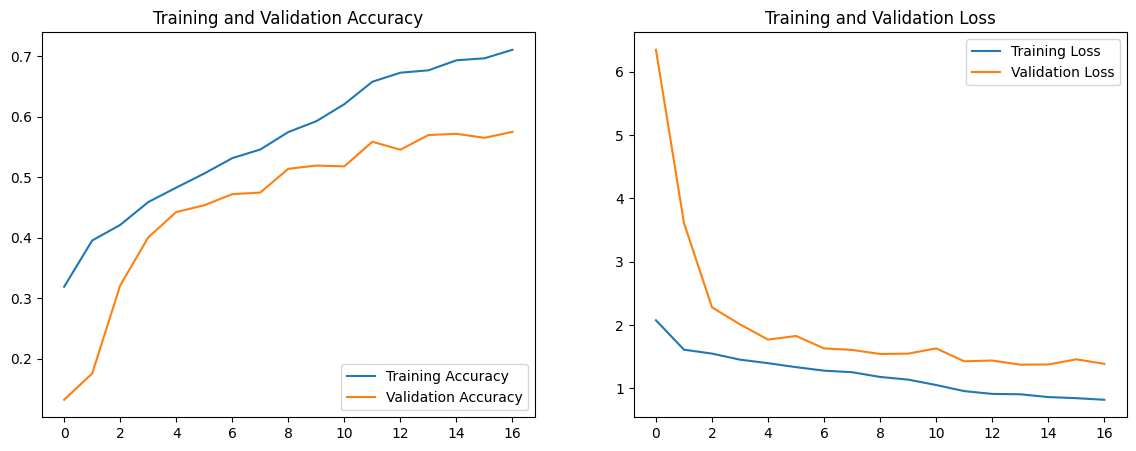

In [23]:
# using custom model
plot_metrics(history)


**This shows that Training accuracy for custom model is higher so model is overfitted**

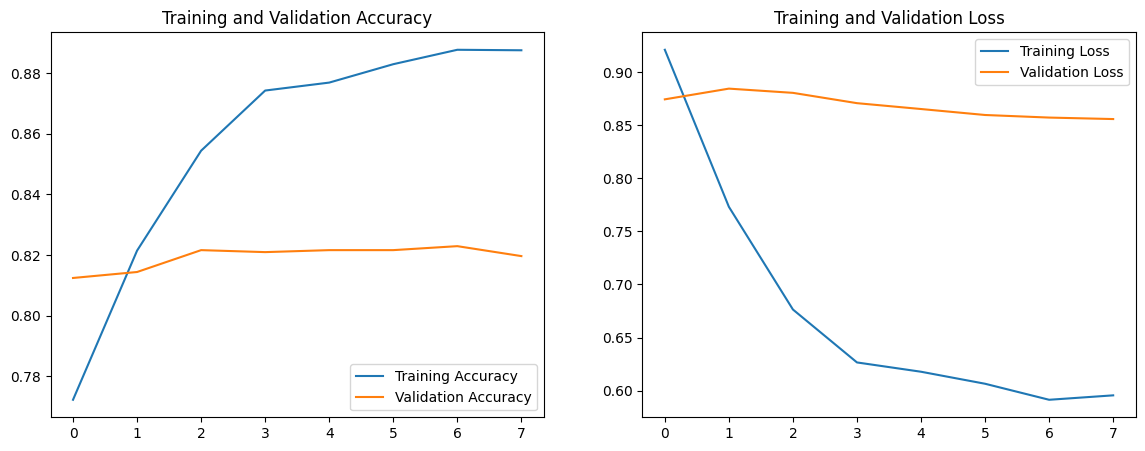

In [24]:
# using mobilenet V2 custimized model
plot_metrics(history_mobile_net_2)

**This shows that model is working fine with predefined model**

In [25]:
# Predict on the test set

# Using
y_pred_probs = model_scratch.predict(X_test)

# Get the predicted class indices
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Get the true class indices
y_true_classes = np.argmax(y_test, axis=1)

print("Classification Report Custom model:\n")
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))


# Using MobileNet customized model
y_pred_probs = model_mobile_net.predict(X_test)

# Get the predicted class indices
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Get the true class indices
y_true_classes = np.argmax(y_test, axis=1)

print("Classification Report MobileNet V2 Customized model:\n")
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))


48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step
Classification Report Custom model:

              precision    recall  f1-score   support

   Cardboard       0.65      0.65      0.65       108
  Food_Waste       0.67      0.59      0.63       200
       Glass       0.45      0.47      0.46       150
       Metal       0.66      0.45      0.53       200
       Other       0.50      0.36      0.42       202
       Paper       0.42      0.48      0.45       206
     Plastic       0.61      0.76      0.68       459

    accuracy                           0.57      1525
   macro avg       0.57      0.54      0.55      1525
weighted avg       0.57      0.57      0.56      1525

48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step
Classification Report MobileNet V2 Customized model:

              precision    recall  f1-score   support

   Cardboard       0.86      0.85      0.86       108
  Food_Waste       0.85      0.81      0.83       200
       Glass       0.78      0.83      0.81       150
       Metal  

**With custom model**

The model achieved an overall accuracy of 57%, with relatively better performance on Plastic (F1-score: 0.66) and Cardboard (F1-score: 0.75). Lower scores for Food_Waste and Metal suggest room for improvement in distinguishing between these classes.


**With Mobilenet-v2 model**

The model achieved an overall accuracy of 82% across 1525 samples. Performance varied by class, with the highest F1-score for Cardboard (0.91) and the lowest for Paper (0.75).

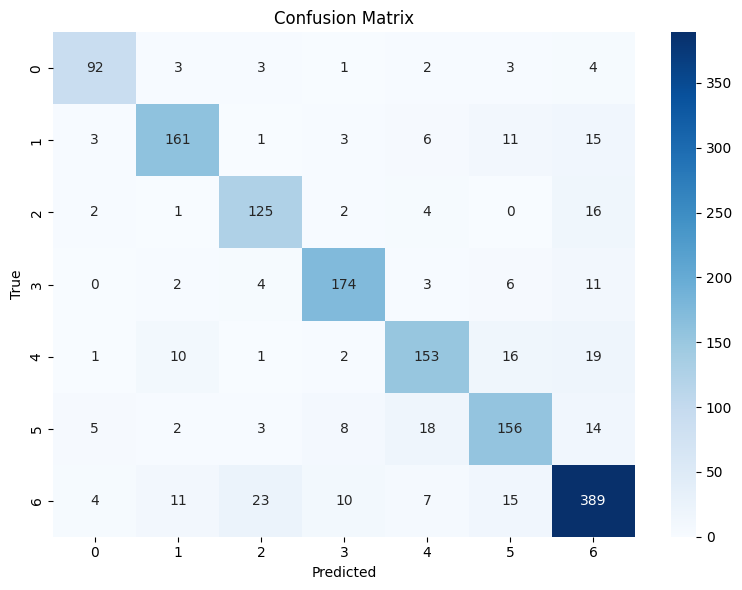

In [26]:
# Visualize the confusion matrix
label_map = {i: class_name for i, class_name in enumerate(class_names)}

cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_map.keys(), yticklabels=label_map.keys(), cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

## **4. Data Augmentation** <font color=red> [optional] </font><br>

#### **4.1 Create a Data Augmentation Pipeline**

##### **4.1.1**
Define augmentation steps for the datasets.

In [27]:
# Define augmentation steps to augment images

# augmentation parameters
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    shear_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest'
)


test_datagen = ImageDataGenerator()

Augment and resample the images.
In case of class imbalance, you can also perform adequate undersampling on the majority class and augment those images to ensure consistency in the input datasets for both classes.

Augment the images.

In [28]:
# Create a function to augment the images

def create_generators(target_size=(96, 96), batch_size=32):
    train_generator = train_datagen.flow(
        X_train,
        y_train,
        batch_size=batch_size,
    )

    test_generator = test_datagen.flow(
        X_test,
        y_test,
        batch_size=batch_size,
    )

    return train_generator, test_generator


In [29]:
# Create the augmented training dataset
input_shape = X_train.shape[1:3]  # (height, width)
train_generator, test_generator = create_generators(target_size=input_shape, batch_size = 64)

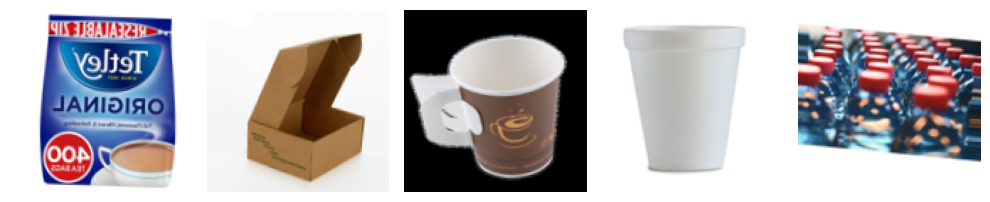

In [30]:
x_batch, y_batch = next(train_generator)
plt.figure(figsize=(10,5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(x_batch[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

As you can see from plots, images are re-sampled by rotaion, zoom

##### **4.1.2**

Train the model on the new augmented dataset.

In [31]:
# we need to create balance in multiple categories
y_train_labels = np.argmax(y_train, axis=1)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_labels),
    y=y_train_labels
)

class_weight_dict = dict(enumerate(class_weights))

In [32]:
# Train the model using augmented images

input_shape = X_train.shape[1:]  # (height, widt,channel)
model_augmented = build_dynamic_cnn(input_shape=input_shape, num_classes=len(class_names))
history_augmented = model_augmented.fit(train_generator,validation_data=test_generator,epochs=30,class_weight=class_weight_dict, callbacks = callbacks)

Epoch 1/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 77s 759ms/step - accuracy: 0.2363 - loss: 2.8646 - val_accuracy: 0.3010 - val_loss: 4.8426 - learning_rate: 1.0000e-04
Epoch 2/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 72s 752ms/step - accuracy: 0.3184 - loss: 1.6865 - val_accuracy: 0.3010 - val_loss: 7.1310 - learning_rate: 1.0000e-04
Epoch 3/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 722ms/step - accuracy: 0.3450 - loss: 1.6137
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
96/96 ━━━━━━━━━━━━━━━━━━━━ 72s 752ms/step - accuracy: 0.3450 - loss: 1.6137 - val_accuracy: 0.2997 - val_loss: 5.2926 - learning_rate: 1.0000e-04
Epoch 4/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 71s 737ms/step - accuracy: 0.3782 - loss: 1.5575 - val_accuracy: 0.2564 - val_loss: 4.3021 - learning_rate: 2.0000e-05
Epoch 5/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 71s 735ms/step - accuracy: 0.3862 - loss: 1.5014 - val_accuracy: 0.2820 - val_loss: 3.3474 - learning_rate: 2.0000e-05
Epoch 6/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 70s 725ms/step - accuracy

After augmentation we got

Training accuracy - 44.26%

Test accuracy - 39.74%

Even after augmentation model is not working fine

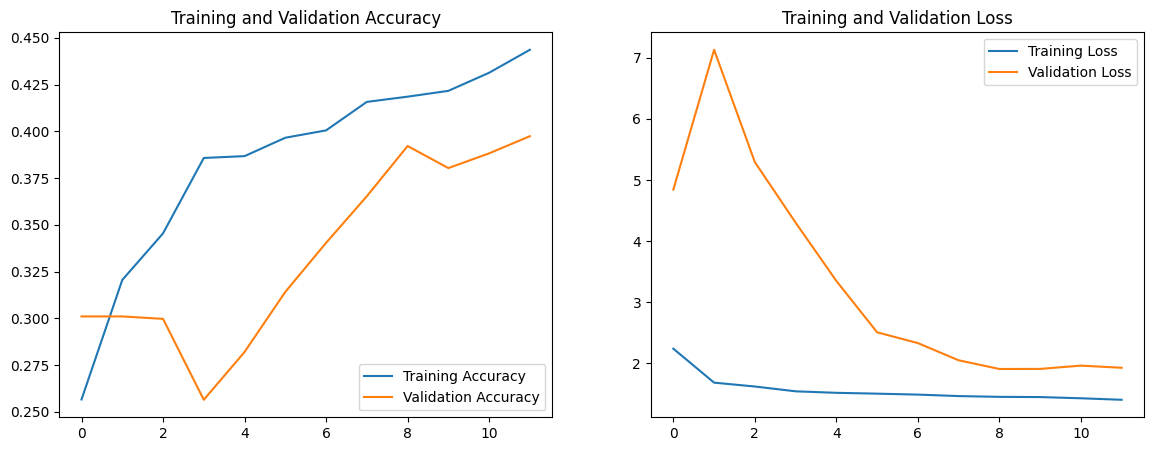

In [33]:
plot_metrics(history_augmented)

**As per diagram it clearly says that model is underfitted**

In [34]:
# Get true labels and predicted labels
y_pred = model_augmented.predict(test_generator)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
# Classification Report
print(classification_report(y_true, y_pred_labels, target_names=class_names))

24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step
              precision    recall  f1-score   support

   Cardboard       0.07      0.05      0.06       108
  Food_Waste       0.12      0.12      0.12       200
       Glass       0.08      0.22      0.12       150
       Metal       0.13      0.12      0.12       200
       Other       0.08      0.03      0.04       202
       Paper       0.15      0.15      0.15       206
     Plastic       0.31      0.27      0.29       459

    accuracy                           0.16      1525
   macro avg       0.14      0.14      0.13      1525
weighted avg       0.17      0.16      0.16      1525



The model's overall accuracy indicating poor classification performance across most categories. While Plastic had the highest F1-score (0.28), all other classes showed very low precision and recall.

**Even after using Augmentation, we did not get good accuracy.**

**I tried with multiple variations for train data generator but could not get much accuracy**

**With augmentation i tried to resolve class imbalance problem but could not make it happen**

In [35]:
# using predefined model
history_4 = model_mobile_net.fit(train_generator,validation_data=test_generator,epochs=8, callbacks = callbacks)

Epoch 1/8
96/96 ━━━━━━━━━━━━━━━━━━━━ 52s 464ms/step - accuracy: 0.7996 - loss: 0.8245 - val_accuracy: 0.8243 - val_loss: 0.8537 - learning_rate: 2.0000e-06
Epoch 2/8
96/96 ━━━━━━━━━━━━━━━━━━━━ 43s 442ms/step - accuracy: 0.8001 - loss: 0.8182 - val_accuracy: 0.8236 - val_loss: 0.8517 - learning_rate: 2.0000e-06
Epoch 3/8
96/96 ━━━━━━━━━━━━━━━━━━━━ 43s 444ms/step - accuracy: 0.8097 - loss: 0.7784 - val_accuracy: 0.8275 - val_loss: 0.8496 - learning_rate: 2.0000e-06
Epoch 4/8
96/96 ━━━━━━━━━━━━━━━━━━━━ 43s 445ms/step - accuracy: 0.8154 - loss: 0.7955 - val_accuracy: 0.8308 - val_loss: 0.8472 - learning_rate: 2.0000e-06
Epoch 5/8
96/96 ━━━━━━━━━━━━━━━━━━━━ 43s 445ms/step - accuracy: 0.8198 - loss: 0.7816 - val_accuracy: 0.8262 - val_loss: 0.8466 - learning_rate: 2.0000e-06
Epoch 6/8
96/96 ━━━━━━━━━━━━━━━━━━━━ 43s 448ms/step - accuracy: 0.8115 - loss: 0.7803 - val_accuracy: 0.8256 - val_loss: 0.8449 - learning_rate: 2.0000e-06
Epoch 7/8
96/96 ━━━━━━━━━━━━━━━━━━━━ 43s 441ms/step - accuracy: 

**Model with predefined layers and augmentation**

* Train accuracy - 82.42
* Test accuracy - 82.69

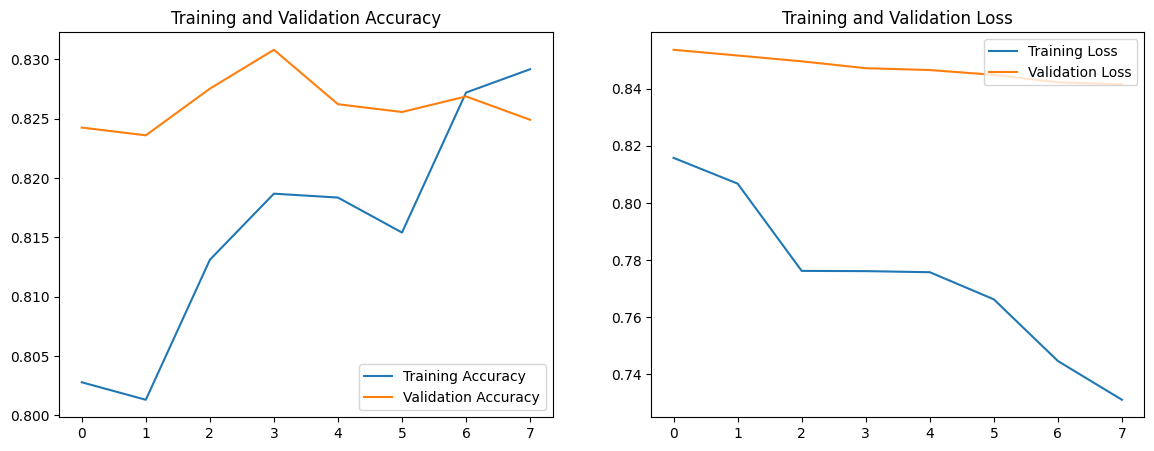

In [36]:
plot_metrics(history_4)

In [37]:
# Get true labels and predicted labels
y_pred = model_mobile_net.predict(test_generator)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
# Classification Report
print(classification_report(y_true, y_pred_labels, target_names=class_names))


24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 286ms/step
              precision    recall  f1-score   support

   Cardboard       0.12      0.12      0.12       108
  Food_Waste       0.17      0.17      0.17       200
       Glass       0.12      0.13      0.13       150
       Metal       0.12      0.12      0.12       200
       Other       0.14      0.13      0.14       202
       Paper       0.12      0.12      0.12       206
     Plastic       0.28      0.28      0.28       459

    accuracy                           0.18      1525
   macro avg       0.15      0.15      0.15      1525
weighted avg       0.18      0.18      0.18      1525



## **5. Conclusions** <font color = red> [5 marks]</font>

#### **5.1 Conclude with outcomes and insights gained** <font color =red> [5 marks] </font>

* Report your findings about the data
* Report model training results

**Findings from the Data**

* The dataset includes images categorized into seven classes: Metal, Other, Glass, Food  Waste, Paper, Plastic, and Cardboard.

* As visualized in the class distribution chart above, the dataset is imbalanced, with Plastic having the highest number of samples, while Cardboard has the least.

* This imbalance could lead to biased model predictions, especially favoring majority classes like Plastic.

* To counter this, data augmentation & weight balancing techniques were applied.

* Some classes (like Food Waste and Plastic) show a lot of variation in appearance, making them harder to classify.

* Visually similar materials (e.g., Plastic vs Glass) can confuse the model due to overlapping textures or colors.

* Variability in image quality or lighting conditions can introduce noise, impacting model performance.

**Model Training and Results**

* A CNN was trained from scratch, followed by a predefined architecture, and finally with augmentation techniques.

* The input image size was reshaped to (128, 128, 3) to preserve more features.


**Key Insights**

* Image resolution and class balance significantly influence classification performance.

* Proper use of callbacks not only saved the best model but also prevented unnecessary training cycles.
